<a href="https://colab.research.google.com/github/JuanM-GG/maestria/blob/main/ml-lote/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torchdyn

In [ ]:
pip install smt

In [4]:
import numpy as np
import torch

from matplotlib import pyplot as plt

from tqdm import tqdm
from torch import nn
from torch.nn.functional import mse_loss
from torchdyn.numerics import odeint

from dataloader import Sampling, load_pendulum_data

In [15]:
# Training data

y0s_domain = [[-1., 1.], [-1., 1.]]
n_steps = 1
step_size = 0.01  
t_span = torch.arange(0., step_size * (n_steps + 1), step_size)

y0s, ys = load_pendulum_data(t_span, y0s_domain, 
                             n_trajectories=20, 
                             sampling=Sampling.RANDOM)


20

In [20]:
print(y0s.shape)
print(ys.shape)

torch.Size([100, 2])
torch.Size([21, 100, 2])


In [7]:
# Network 
class RNN(nn.Module):

    def __init__(self, n_states):
        super().__init__()

        #  The batch_first argument is set to True, which means that the input and 
        #  output tensors are expected to have the batch size as the first dimension.

        # The double method of the RNN model converts the model's parameters to
        # double-precision floating-point numbers.

        self.rnn = nn.RNN(n_states, 
                          n_states, 
                          batch_first=True).double()

    def forward(self, y0s):
        # unsqueeze is a function in PyTorch that adds a new dimension to a tensor. 
        # The new dimension is inserted at the specified position dim, and has a size of 1.
        y0s = y0s.unsqueeze(dim=1)
        out, hidden = self.rnn(y0s, torch.swapaxes(y0s, 0, 1))
        return hidden.squeeze(dim=0)

In [8]:
model = RNN(n_states=2)
opt = torch.optim.Adam(model.parameters())

In [24]:
print(y0s.shape)
print(y0s.unsqueeze(dim=1).shape)

torch.Size([100, 2])
torch.Size([100, 1, 2])


In [ ]:
# Training
epochs = 20
progress = tqdm(range(epochs), 'Training')
losses = []

for _ in progress:
    _, y_pred = odeint(lambda t, y: model(y), y0s, t_span, 'euler')

    loss = mse_loss(y_pred, ys)
    loss.backward()
    opt.step()
    opt.zero_grad()

    losses.append(loss.item())
    progress.set_description(f'loss: {loss.item()}')

In [10]:
# Test data 

y0s_domain = [[-1., 1.], [-1., 1.]]
n_steps = 20
step_size = 0.01  
t_span = torch.arange(0., step_size * (n_steps + 1), step_size)

y0s, ys = load_pendulum_data(t_span, y0s_domain, n_trajectories=10, sampling=Sampling.GRID)
_, y_pred = odeint(lambda t, y: model(y), y0s, t_span, 'euler')

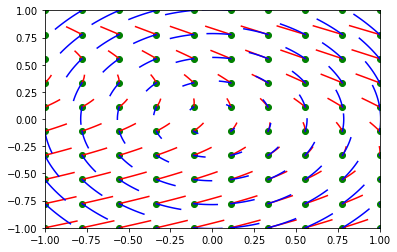

In [11]:
# Plot 
plt.plot(y_pred.detach().numpy()[:, :, 1], y_pred.detach().numpy()[:, :, 0], color='r')
plt.plot(ys.numpy()[:, :, 1], ys.numpy()[:, :, 0], color='b')
plt.scatter(ys[0, :, 1], ys[0, :, 0], color='g')
plt.ylim(y0s_domain[0])
plt.xlim(y0s_domain[1])
plt.show()
